In [10]:
import fastjet as fj
import pythia8
from recursivetools import pyrecursivetools as rt
from lundplane import pylundplane as lund
from pythiafjtools import pypythiafjtools as pyfj
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
from tqdm import tnrange, tqdm_notebook
import joblib
import os

In [2]:
def deltas(jets, jets0):
    for i in range(len(jets)):
        yield jets0[i].perp() - jets[i].perp()

def create_and_init_pythia(config_strings=[]):
    pythia = pythia8.Pythia()
    for s in config_strings:
        pythia.readString(s)
    for extra_s in ["Next:numberShowEvent = 0", "Next:numberShowInfo = 0", "Next:numberShowProcess = 0"]:
        pythia.readString(extra_s)
    if pythia.init():
        return pythia
    return None

sconfig_pythia = [ "Beams:eCM = 8000.", "HardQCD:all = on", "PhaseSpace:pTHatMin = 20."]
pythia = create_and_init_pythia(sconfig_pythia)

# set up our jet definition and a jet selector
jet_R0 = 0.4
jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_R0)
selector = fj.SelectorPtMin(20.0) & fj.SelectorPtMax(40.0) & fj.SelectorAbsEtaMax(1)
sd = rt.SoftDrop(0, 0.1, 1.0)

In [15]:
all_jets = []
for iEvent in tqdm_notebook(range(100), 'event'):
    if not pythia.next(): continue
    parts = pyfj.vectorize(pythia, True, -1, 1, False)
    jets = jet_selector(jet_def(parts))
    all_jets.extend(jets)

In [16]:
jet_def_lund = fj.JetDefinition(fj.cambridge_algorithm, 1.0)
lund_gen = lund.LundGenerator(jet_def_lund)

In [17]:
%%time
lunds = [lund_gen.result(j) for j in all_jets]

CPU times: user 577 µs, sys: 61 µs, total: 638 µs
Wall time: 645 µs


In [18]:
%%time
log_kt = []
log_1oDelta = []
for l in lunds:
    for s in l:
        log_kt.append(math.log(s.kt()))
        log_1oDelta.append(math.log(1./s.Delta()))

CPU times: user 765 µs, sys: 1 µs, total: 766 µs
Wall time: 772 µs


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.91739709, 0.95405441, 0.99071172, 1.02736903, 1.06402635,
        1.10068366, 1.13734098, 1.17399829, 1.2106556 , 1.24731292,
        1.28397023, 1.32062755, 1.35728486, 1.39394217, 1.43059949,
        1.4672568 , 1.50391412, 1.54057143, 1.57722874, 1.61388606,
        1.65054337, 1.68720068, 1.723858  , 1.76051531, 1.79717263,
        1.83382994, 1.87048725, 1.90714457, 1.94380188, 1.9804592 ,
        2.01711651, 2.05377382, 2.09043114, 2.12708845, 2.16374577,
        2.20040308, 2.23706039, 2.27371771, 2.31037502, 2.34703233,
        2.38368965, 2.42034696, 2.45700428, 2.49366159, 2.5303189 ,
        2.56697622, 2.60363353, 2.64029085, 2.67694816, 2.71360547,
        2.75026279, 2.7869201 , 2.82357741, 2.86023473, 2.89689204,
   

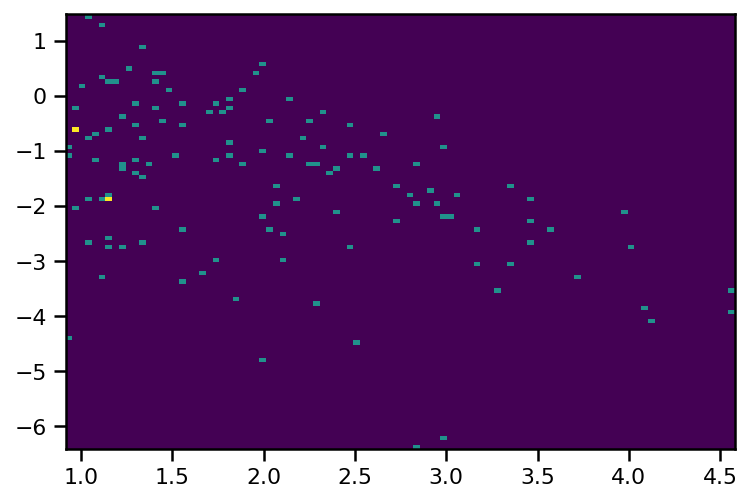

In [19]:
plt.hist2d(log_1oDelta, log_kt, bins=100)

In [20]:
if not os.path.exists('test_lund_2d.joblib'):
    joblib.dump([log_1oDelta, log_kt], 'test_lund_2d.joblib') 

In [21]:
xy = joblib.load('test_lund_2d.joblib')

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 4., 2., 2.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.673456  , 0.75306704, 0.83267807, 0.91228911, 0.99190014,
        1.07151117, 1.15112221, 1.23073324, 1.31034428, 1.38995531,
        1.46956634, 1.54917738, 1.62878841, 1.70839945, 1.78801048,
        1.86762152, 1.94723255, 2.02684358, 2.10645462, 2.18606565,
        2.26567669, 2.34528772, 2.42489875, 2.50450979, 2.58412082,
        2.66373186, 2.74334289, 2.82295393, 2.90256496, 2.98217599,
        3.06178703, 3.14139806, 3.2210091 , 3.30062013, 3.38023116,
        3.4598422 , 3.53945323, 3.61906427, 3.6986753 , 3.77828634,
        3.85789737, 3.9375084 , 4.01711944, 4.09673047, 4.17634151,
        4.25595254, 4.33556358, 4.41517461, 4.49478564, 4.57439668,
        4.65400771, 4.73361875, 4.81322978, 4.89284081, 4.97245185,
   

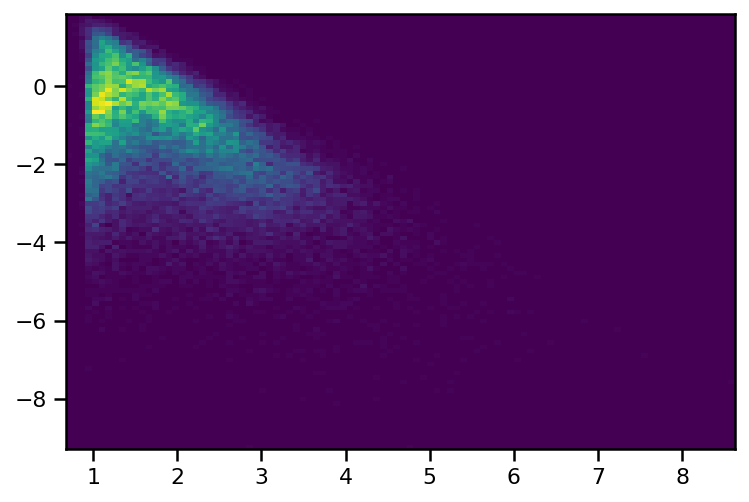

In [22]:
plt.hist2d(xy[0], xy[1], bins=100)